### Common Words - Caption analysis

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from datetime import datetime
import pytz
from wordcloud import WordCloud
from nltk.util import ngrams
from datetime import datetime

# Download NLTK Ressourcen
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hannahschlaucher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hannahschlaucher/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hannahschlaucher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Data Filtering and Text Preprocessing**

In [44]:
# Load dataset
df = pd.read_csv("../data/raw_data/posts_transcripts_raw.csv")

In [45]:
# Convert timestamp to datetime format with UTC awareness
df["createTimeISO"] = pd.to_datetime(df["createTimeISO"], utc=True)

# Filter for posts from the last 6 months (timezone-aware)
six_months_ago = pd.Timestamp(datetime.today(), tz="UTC") - pd.DateOffset(months=6)
df = df[df["createTimeISO"] >= six_months_ago]

# Create a 'week' column for grouping
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_76715/2075218460.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


In [48]:
# Keep only English and German posts
df = df[df["textLanguage"].isin(["en", "de"])]

In [49]:
# Keep rows with non-empty captions and remove hashtags from text
df = df[df["text"].notna()]
df["text"] = df["text"].astype(str).apply(lambda x: re.sub(r"#\w+", "", x))

In [50]:
# Standard stopwords (German + English)
standard_stopwords = set(stopwords.words("german")) | set(stopwords.words("english"))

# Custom stopwords (slang, emojis, filler words)
custom_stopwords = {
    "i", "you", "it", "me", "this", "that", "we", "she", "he", "they", "u", "ur",
    "my", "your", "yours", "ours", "their", "its", "use", "like", "get", "need", 
    "please", "one", "would", "watch", "want", "que", "tbh", "idk", "fr", 
    "literally", "actually", "honestly", "kinda", "thing", "stuff", 
    "😭", "😂", "✨", "💀", "💅", "🥰", "😩", "😅", "🥺", "😳"
}

# Combine all stopwords
combined_stopwords = standard_stopwords | custom_stopwords

In [51]:
# Tokenize and clean each text entry
def clean_tokens(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)  # Keep only letters
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in combined_stopwords and len(w) > 2]
    return tokens

In [52]:
# Apply tokenization to captions
df["tokens"] = df["text"].apply(clean_tokens)

**Weekly Word Frequency Analysis**

Top 5 most common words per week

In [53]:
# Flatten token list per post; one token per row
df_exploded = df.explode("tokens").dropna(subset=["tokens"])

In [54]:
# Group by week and get top 5 most frequent tokens per week
weekly_words = (
    df_exploded.groupby("week")["tokens"]
    .apply(lambda x: Counter(x).most_common(5))
).reset_index(name="top_words")

In [55]:
# Expand list of (word, count) tuples to separate rows
df_topwords = weekly_words.explode("top_words").dropna()

# Split tuples into individual columns
df_topwords[["word", "count"]] = pd.DataFrame(
    df_topwords["top_words"].tolist(), index=df_topwords.index
)

In [56]:
# Assign rank to each word per week
df_topwords["rank"] = df_topwords.groupby("week").cumcount() + 1

# Keep clean structure and sort by recent weeks
df_topwords = df_topwords[["week", "rank", "word", "count"]].sort_values("week", ascending=False)
df_topwords.head(20)

,week,rank,word,count
26,2025-07-07,5,glow,15
26,2025-07-07,4,routine,31
26,2025-07-07,3,skin,35
26,2025-07-07,2,skincare,40
26,2025-07-07,1,haut,50
25,2025-06-30,3,routine,110
25,2025-06-30,1,haut,141
25,2025-06-30,2,skin,118
25,2025-06-30,4,skincare,107
25,2025-06-30,5,serum,46


**Top N-Gram Frequency Analysis**

In [57]:
# Flatten unigrams
all_unigrams = [word for tokens in df["tokens"] for word in tokens]

# Create bigrams and trigrams from tokens
all_bigrams = [" ".join(bg) for tokens in df["tokens"] for bg in ngrams(tokens, 2)]
all_trigrams = [" ".join(tg) for tokens in df["tokens"] for tg in ngrams(tokens, 3)]

In [58]:
# Top 10 most common n-grams
top10_unigrams = Counter(all_unigrams).most_common(10)
top10_bigrams = Counter(all_bigrams).most_common(10)
top10_trigrams = Counter(all_trigrams).most_common(10)

In [59]:
# Create DataFrames for each n-gram type
df_uni = pd.DataFrame(top10_unigrams, columns=["Unigram", "Unigram Count"])
df_bi = pd.DataFrame(top10_bigrams, columns=["Bigram", "Bigram Count"])
df_tri = pd.DataFrame(top10_trigrams, columns=["Trigram", "Trigram Count"])

# Combine for compact display
df_side_by_side = pd.concat([df_uni, df_bi, df_tri], axis=1)

# Show result
df_side_by_side

,Unigram,Unigram Count,Bigram,Bigram Count,Trigram,Trigram Count
0,haut,3313,skincare routine,854,skin care routine,102
1,skin,2468,skin care,234,morning skincare routine,98
2,skincare,2165,medicube global,204,night skincare routine,49
3,routine,1948,strahlende haut,177,nighttime skincare routine,37
4,serum,993,care routine,144,skincare routine routine,37
5,glow,905,anua global,138,spendet intensiv feuchtigkeit,35
6,beauty,791,morning skincare,135,routine routine next,35
7,cream,710,eye cream,133,night time skincare,30
8,products,632,anti aging,117,acne prone skin,29
9,pflege,609,products used,117,first aid beauty,29


In [60]:
print("Top 10 Bigrams:")
print(top10_bigrams)
print("Top 10 Trigrams:")
print(top10_trigrams)

Top 10 Bigrams:
[('skincare routine', 854), ('skin care', 234), ('medicube global', 204), ('strahlende haut', 177), ('care routine', 144), ('anua global', 138), ('morning skincare', 135), ('eye cream', 133), ('anti aging', 117), ('products used', 117)]
Top 10 Trigrams:
[('skin care routine', 102), ('morning skincare routine', 98), ('night skincare routine', 49), ('nighttime skincare routine', 37), ('skincare routine routine', 37), ('spendet intensiv feuchtigkeit', 35), ('routine routine next', 35), ('night time skincare', 30), ('acne prone skin', 29), ('first aid beauty', 29)]


**Top N-Grams in Most Recent Week (Relative Frequencies)**

In [61]:
# Generate unigrams, bigrams, trigrams
df["unigrams"] = df["tokens"]
df["bigrams"] = df["tokens"].apply(lambda t: [" ".join(g) for g in ngrams(t, 2)] if len(t) > 1 else [])
df["trigrams"] = df["tokens"].apply(lambda t: [" ".join(g) for g in ngrams(t, 3)] if len(t) > 2 else [])
df["all_ngrams"] = df["unigrams"] + df["bigrams"] + df["trigrams"]

In [62]:
# Create flattened (week, ngram) dataset
records = [(row["week"], ngram) for _, row in df.iterrows() for ngram in row["all_ngrams"]]
df_all = pd.DataFrame(records, columns=["week", "ngram"])

In [63]:
# Count ngram mentions per week and normalize by caption count
weekly_counts = df_all.groupby(["week", "ngram"]).size().reset_index(name="count")
captions_per_week = df.groupby("week")["text"].count().reset_index(name="total_captions")
weekly_counts = weekly_counts.merge(captions_per_week, on="week", how="left")
weekly_counts["mention_percent"] = (weekly_counts["count"] / weekly_counts["total_captions"]) * 100
weekly_counts["type"] = weekly_counts["ngram"].apply(lambda x: "Unigram" if len(x.split()) == 1 else "Bigram" if len(x.split()) == 2 else "Trigram")

In [64]:
# Select top 5 ngrams per type across the full time range
top_ngrams_by_type = (
    weekly_counts.groupby(["type", "ngram"])["mention_percent"]
    .sum()
    .reset_index()
    .sort_values(["type", "mention_percent"], ascending=[True, False])
    .groupby("type")
    .head(5)
)

top_weekly = weekly_counts.merge(top_ngrams_by_type[["type", "ngram"]], on=["type", "ngram"])

In [65]:
# Pivot for line plots
df_uni = top_weekly[top_weekly["type"] == "Unigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)
df_bi = top_weekly[top_weekly["type"] == "Bigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)
df_tri = top_weekly[top_weekly["type"] == "Trigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)

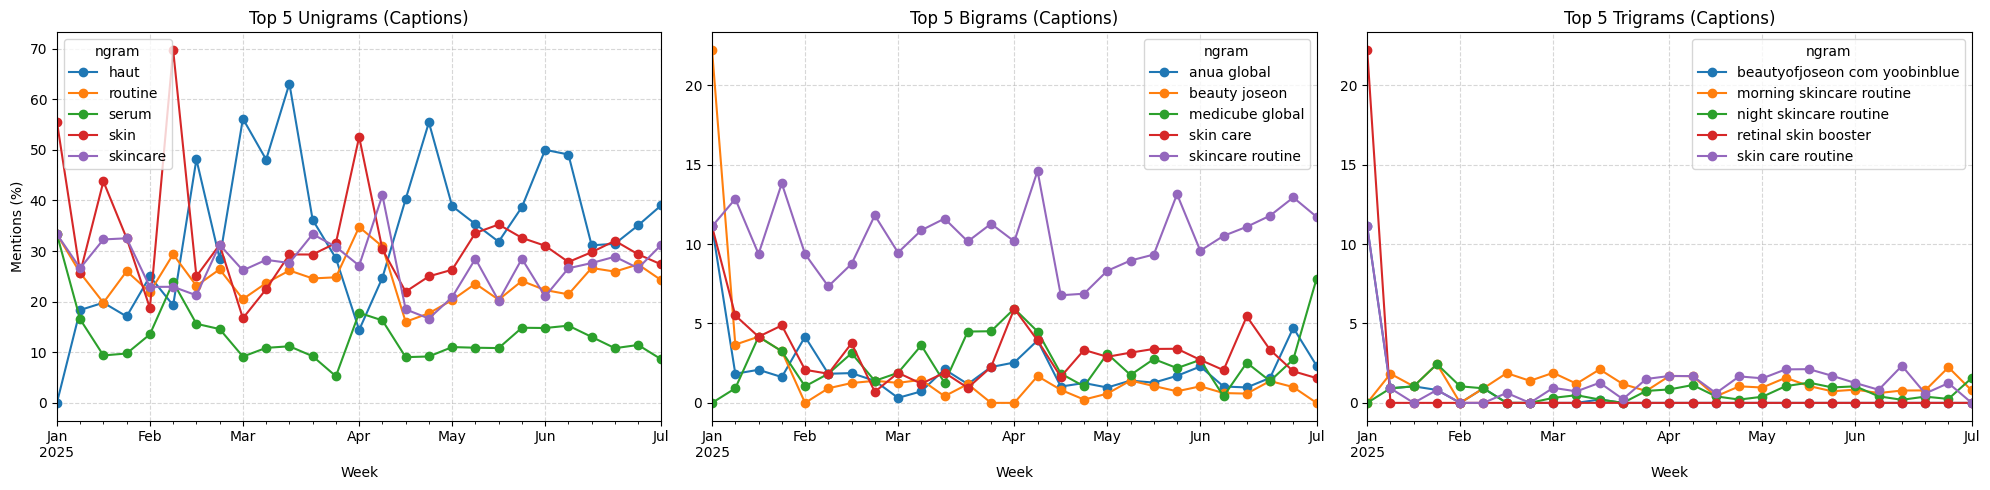

In [66]:
# Plot weekly trends for top 5 ngrams per type
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

df_uni.plot(ax=axes[0], marker="o")
axes[0].set_title("Top 5 Unigrams (Captions)")
axes[0].set_xlabel("Week")
axes[0].set_ylabel("Mentions (%)")
axes[0].grid(True, linestyle="--", alpha=0.5)

df_bi.plot(ax=axes[1], marker="o")
axes[1].set_title("Top 5 Bigrams (Captions)")
axes[1].set_xlabel("Week")
axes[1].grid(True, linestyle="--", alpha=0.5)

df_tri.plot(ax=axes[2], marker="o")
axes[2].set_title("Top 5 Trigrams (Captions)")
axes[2].set_xlabel("Week")
axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [67]:
# Show top 10 ngrams from the most recent week with relative frequencies
latest_week = df["week"].max()
df_latest = df[df["week"] == latest_week]
ngrams_latest = df_latest["unigrams"] + df_latest["bigrams"] + df_latest["trigrams"]
ngrams_flat = [ngram for ngrams_list in ngrams_latest for ngram in ngrams_list]
total = len(ngrams_flat)
top10 = Counter(ngrams_flat).most_common(10)

df_latest_summary = pd.DataFrame(top10, columns=["Ngram", "Count"])
df_latest_summary["%"] = (df_latest_summary["Count"] / total) * 100
df_latest_summary = df_latest_summary.round(2)

print(f"Top 10 Ngrams in Latest Week ({latest_week.strftime('%Y-%m-%d')}) – Relative Frequency")
df_latest_summary

Top 10 Ngrams in Latest Week (2025-07-07) – Relative Frequency


,Ngram,Count,%
0,haut,50,0.87
1,skincare,40,0.70
2,skin,35,0.61
3,routine,31,0.54
4,skincare routine,15,0.26
5,glow,15,0.26
6,global,14,0.24
7,day,12,0.21
8,medicube,12,0.21
9,serum,11,0.19


**Wordcloud of most common words for last 6 months**

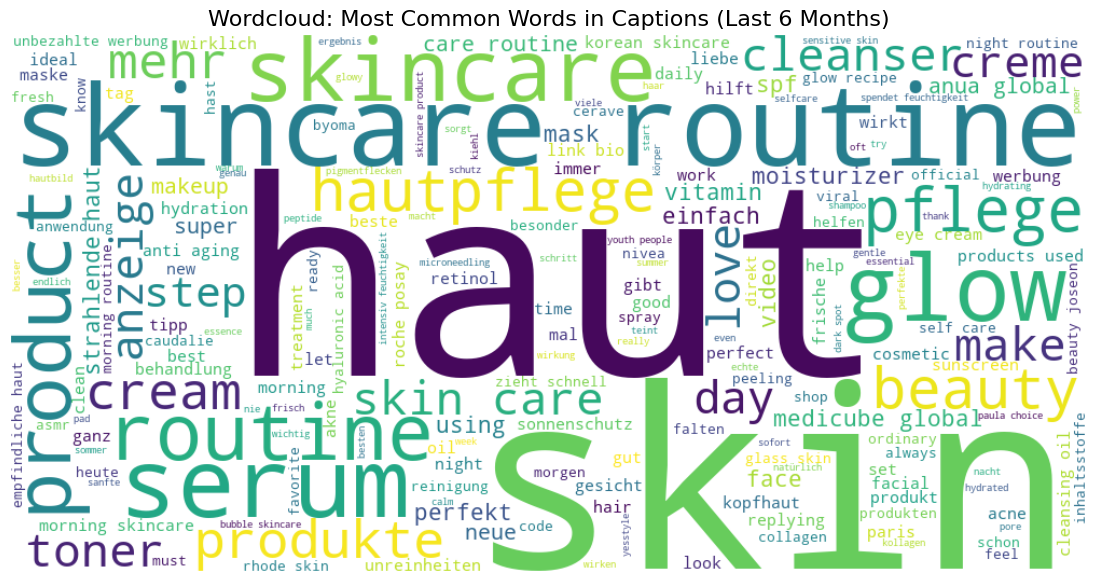

In [68]:
# Flatten token lists to a single Series
all_tokens = df["tokens"].explode().dropna()

# Join all tokens into a single string
text = " ".join(all_tokens)

# Generate wordcloud
wc = WordCloud(width=1000, height=500, background_color="white", colormap="viridis").generate(text)

# Show wordcloud
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud: Most Common Words in Captions (Last 6 Months)", fontsize=16)
plt.show()

**Top keyword trends per week (last 6 monts)**

In [69]:
# Create 'week' column from timestamp
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

# Explode token list into one word per row
df_weekly = df.explode("tokens")

# Count how often each word appears per week
word_counts = df_weekly.groupby(["week", "tokens"]).size().reset_index(name="count")

# Keep only words that occur more than 20 times overall (adjust threshold if needed)
top_words = word_counts.groupby("tokens")["count"].sum()
top_words = top_words[top_words > 20].index

# Filter to keep only frequent words
filtered = word_counts[word_counts["tokens"].isin(top_words)]

# Create pivot table (words = rows, weeks = columns)
pivot_weekly = filtered.pivot_table(index="tokens", columns="week", values="count", fill_value=0)

# Sort by total mentions across all weeks
pivot_weekly["total"] = pivot_weekly.sum(axis=1)
pivot_weekly = pivot_weekly.sort_values("total", ascending=False).drop(columns="total")

# Count number of posts per week (non-exploded)
weekly_post_counts = df.groupby("week").size()

# Convert to single-row DataFrame and label the index
weekly_post_counts = pd.DataFrame([weekly_post_counts])
weekly_post_counts.index = ["total_posts"]

# Add total_posts row to the top of the pivot table
pivot_with_totals = pd.concat([weekly_post_counts, pivot_weekly])

# Show top 15 rows including total_posts
pivot_with_totals.head(16)

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_76715/2387249334.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


week,2025-01-06,2025-01-13,2025-01-20,2025-01-27,2025-02-03,2025-02-10,2025-02-17,2025-02-24,2025-03-03,2025-03-10,...,2025-05-05,2025-05-12,2025-05-19,2025-05-26,2025-06-02,2025-06-09,2025-06-16,2025-06-23,2025-06-30,2025-07-07
total_posts,9.0,109.0,96.0,123.0,96.0,109.0,160.0,144.0,317.0,414.0,...,517.0,569.0,471.0,411.0,480.0,485.0,514.0,509.0,402.0,128.0
haut,0.0,20.0,19.0,21.0,24.0,21.0,77.0,41.0,178.0,199.0,...,201.0,201.0,150.0,159.0,240.0,238.0,160.0,160.0,141.0,50.0
skin,5.0,28.0,42.0,40.0,18.0,76.0,40.0,45.0,53.0,93.0,...,136.0,191.0,166.0,134.0,149.0,135.0,153.0,163.0,118.0,35.0
skincare,3.0,29.0,31.0,40.0,22.0,25.0,34.0,45.0,83.0,117.0,...,108.0,162.0,95.0,117.0,101.0,129.0,142.0,147.0,107.0,40.0
routine,3.0,28.0,19.0,32.0,21.0,32.0,37.0,38.0,65.0,98.0,...,105.0,134.0,96.0,99.0,107.0,104.0,137.0,132.0,110.0,31.0
serum,3.0,18.0,9.0,12.0,13.0,26.0,25.0,21.0,29.0,45.0,...,57.0,62.0,51.0,61.0,71.0,74.0,67.0,55.0,46.0,11.0
glow,1.0,5.0,5.0,7.0,3.0,16.0,20.0,12.0,41.0,44.0,...,52.0,51.0,55.0,56.0,49.0,52.0,70.0,68.0,36.0,15.0
beauty,3.0,9.0,8.0,9.0,10.0,6.0,15.0,14.0,38.0,40.0,...,38.0,48.0,49.0,48.0,48.0,33.0,53.0,46.0,28.0,4.0
cream,1.0,11.0,4.0,8.0,6.0,9.0,6.0,14.0,25.0,46.0,...,46.0,62.0,37.0,44.0,40.0,37.0,45.0,33.0,39.0,6.0
products,1.0,9.0,7.0,9.0,6.0,6.0,11.0,14.0,15.0,32.0,...,35.0,49.0,43.0,31.0,34.0,25.0,36.0,40.0,35.0,11.0


**Top keywords over time**

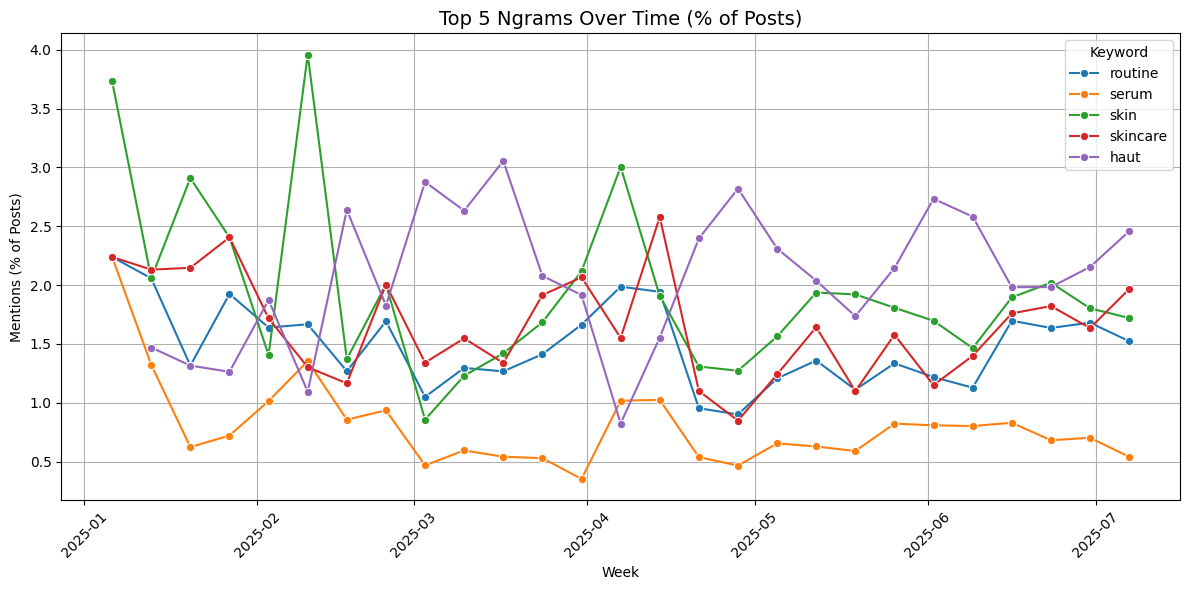

In [70]:
# Count all ngram mentions (e.g. from 'tokens' column) over the whole period
top_ngrams = (
    df_exploded["tokens"]
    .value_counts()
    .head(5)
    .index
    .tolist()
)

# Filter only those top 5 ngrams
df_top_ngrams = df_exploded[df_exploded["tokens"].isin(top_ngrams)]

# Group and count
trend_data = (
    df_top_ngrams.groupby(["week", "tokens"])
    .size()
    .reset_index(name="count")
)

# Total posts per week
posts_per_week = df_exploded.groupby("week")["text"].count().reset_index(name="total_posts")

# Merge and normalize
trend_data = trend_data.merge(posts_per_week, on="week", how="left")
trend_data["mention_percent"] = (trend_data["count"] / trend_data["total_posts"]) * 100

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x="week", y="mention_percent", hue="tokens", marker="o")
plt.title("Top 5 Ngrams Over Time (% of Posts)", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Mentions (% of Posts)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Keyword")
plt.show()


**Top trending keywords - 4 weeks growth**

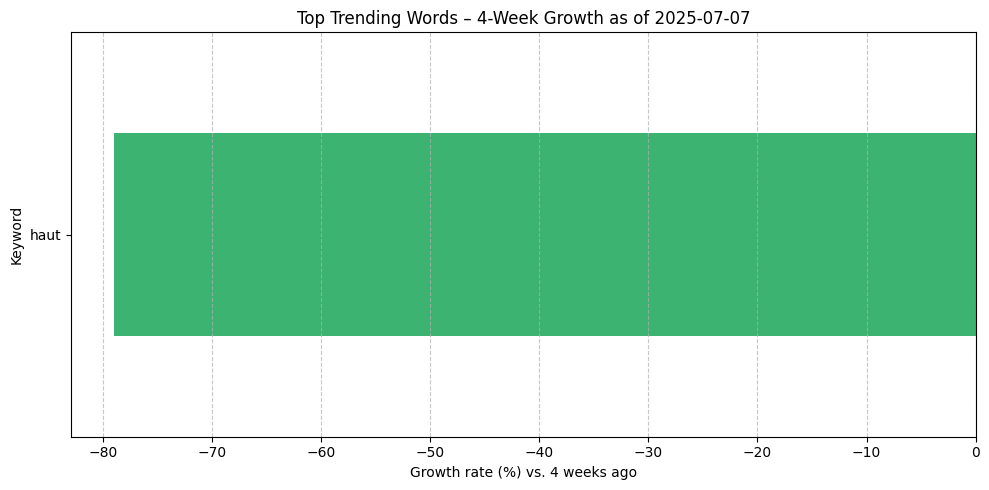

In [71]:
# Get the most recent and the one before that (4 weeks ago)
latest_week = pivot_weekly.columns[-1]
previous_week = pivot_weekly.columns[-5]  # 4 weeks ago

# Calculate percentage growth, avoiding division by zero
previous_counts = pivot_weekly[previous_week].replace(0, 1)
growth_2w = ((pivot_weekly[latest_week] - pivot_weekly[previous_week]) / previous_counts) * 100

# Keep only words that appear at least 50 times in the latest week
min_count = 50
min_previous = 25 # Minimum count in the previous week
valid_words = (pivot_weekly[latest_week] >= min_count) & (pivot_weekly[previous_week] >= min_previous)
trending_2w = growth_2w[valid_words].sort_values(ascending=False)

# Select top 10 trending words
top_trending = trending_2w.head(10)

# Visualize
plt.figure(figsize=(10, 5))
top_trending[::-1].plot(kind="barh", color="mediumseagreen")
plt.title(f"Top Trending Words – 4-Week Growth as of {latest_week.date()}")
plt.xlabel("Growth rate (%) vs. 4 weeks ago")
plt.ylabel("Keyword")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Trending words over time

<Figure size 1600x600 with 0 Axes>

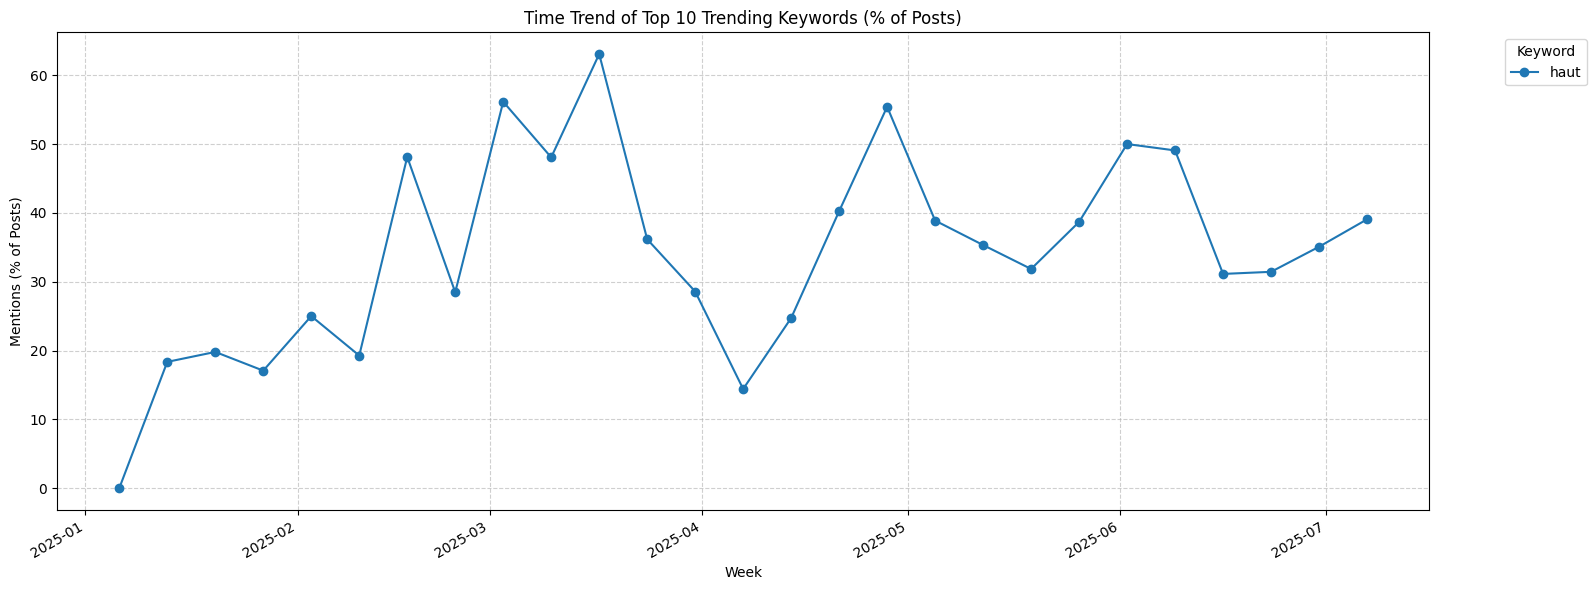

In [72]:
# Number of trending words to show
top_n = 10

# Get the top trending words from 2-week growth analysis
top_trending_words = trending_2w.head(top_n).index.tolist()

# Filter the pivot table to include only those trending words
pivot_trending = pivot_weekly.loc[top_trending_words]

# Transpose so weeks are rows, words are columns
pivot_trending = pivot_trending.T  # index = week, columns = keywords

# Get number of posts per week
posts_per_week = df.groupby(df["week"])["tokens"].count()
posts_per_week.name = "total_posts"

# Normalize keyword mentions by total posts per week
pivot_trending_normalized = pivot_trending.div(posts_per_week, axis=0) * 100  # in percent

# Plot
plt.figure(figsize=(16, 6))
pivot_trending_normalized.plot(marker='o', figsize=(16, 6))
plt.title(f"Time Trend of Top {top_n} Trending Keywords (% of Posts)")
plt.xlabel("Week")
plt.ylabel("Mentions (% of Posts)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Note: We also looked into chunk analysis however this did not provide significant insights compared to uni-,bi-,trigrams